## 1. Setup and Imports <a name="setup"></a>

First, we need to set up the Python path to import our modules.


In [1]:
import sys
import os

# Add parent directory to path to import src modules
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

# Now we can import our modules
from src.constants import (
    cutoffFrequency, fs, stimOnset, stimOffset, 
    numTrials, numSessions, nyquistFrequency
)
from src.data_loader import load_data, inspect_data
from src.outlier_detection import (
    find_tone_indices, visualize_raw_data, compare_tone_responses,
    calculate_high_freq_power, detect_outliers, remove_outliers,
    print_rejection_summary, visualize_cleaned_data, store_outlier_data,
    visualize_outliers
)
from src.filtering import setup_filtering_parameters, apply_filter, visualize_filtering
from src.analysis import (
    method1_psth_analysis, visualize_method1_time, visualize_method1_frequency,
    method2_correlation_analysis, visualize_method2_correlation,
    combined_sessions_analysis
)
from src.data_saver import save_results

import numpy as np
import matplotlib.pyplot as plt

print("All modules imported successfully!")


All modules imported successfully!


## 2. Loading Constants <a name="constants"></a>

The constants module contains all the configuration parameters used throughout the analysis.


In [2]:
# Display constants
print("Analysis Parameters:")
print(f"  Sampling frequency (fs): {fs} Hz")
print(f"  Cutoff frequency: {cutoffFrequency} Hz")
print(f"  Stimulus onset: {stimOnset} ms")
print(f"  Stimulus offset: {stimOffset} ms")
print(f"  Number of sessions: {numSessions}")
print(f"  Number of trials: {numTrials}")
print(f"  Nyquist frequency: {nyquistFrequency} Hz")


Analysis Parameters:
  Sampling frequency (fs): 10000 Hz
  Cutoff frequency: 1000 Hz
  Stimulus onset: 100 ms
  Stimulus offset: 150 ms
  Number of sessions: 4
  Number of trials: 200
  Nyquist frequency: 5000.0 Hz


## 3. Data Loading <a name="data-loading"></a>

Load the MATLAB data file containing the LFP recordings.


In [3]:
# Load data
# Make sure mouseLFP.mat is in the data/ directory
mat_file_path = '../data/mouseLFP.mat'

if os.path.exists(mat_file_path):
    DATA, dataSamples = load_data(mat_file_path)
    print(f"Data loaded successfully!")
    print(f"  DATA shape: {DATA.shape}")
    print(f"  Number of samples per trial: {dataSamples}")
    
    # Optional: Inspect data structure
    # inspect_data(DATA)
else:
    print(f"Warning: {mat_file_path} not found.")
    print("Please ensure the data file is in the data/ directory.")


Data loaded successfully!
  DATA shape: (4, 7)
  Number of samples per trial: 3000


## 4. Outlier Detection <a name="outlier-detection"></a>

### 4.1 Find Tone Indices

First, we identify which trials correspond to low and high tone conditions for each session.


In [4]:
# Find tone indices for each session
toneIndices = find_tone_indices(DATA, numSessions)

# Create time array for visualization
time_ms = np.arange(dataSamples) / fs * 1000


Session 1:
 unique tone : [ 9513.374023 19026.294922]
  Low tone trials: 101
  High tone trials: 99
Session 2:
 unique tone : [11313.304688 19026.294922]
  Low tone trials: 101
  High tone trials: 99
Session 3:
 unique tone : [11313.304688 19026.294922]
  Low tone trials: 101
  High tone trials: 99
Session 4:
 unique tone : [19026.294922 22626.070313]
  Low tone trials: 99
  High tone trials: 101


### 4.2 Visualize Raw Data (Optional)

Visualize the raw data to inspect signal quality before outlier removal.


In [5]:
# Uncomment to visualize raw data
# visualize_raw_data(DATA, toneIndices, numSessions)
# compare_tone_responses(DATA, toneIndices, numSessions, time_ms, stimOnset, stimOffset)


### 4.3 Detect Outliers

Use high-frequency power analysis to detect noisy trials. Outliers are identified using the IQR (Interquartile Range) method.


In [6]:
# Detect outliers using high-frequency power analysis
# High-frequency noise typically appears above 500 Hz
high_freq_min = 500  # Hz
high_freq_max = 1000  # Hz (cutoff frequency)

high_freq_powers, outlier_flags = detect_outliers(
    DATA, toneIndices, numSessions, fs, 
    high_freq_min=high_freq_min, 
    high_freq_max=high_freq_max
)

print("\nOutlier detection completed!")



Outlier detection completed!


### 4.4 Remove Outliers

Remove detected outliers and create cleaned datasets.


In [7]:
# Remove outliers and create cleaned data
rawData, validToneIndices, trialsBeforeRejection, trialsAfterRejection = remove_outliers(
    DATA, toneIndices, outlier_flags, numSessions
)

# Print summary of outlier removal
print_rejection_summary(trialsBeforeRejection, trialsAfterRejection, numSessions)



Overall (All Sessions, All Tones):
----------------------------------------------------------------------
  Before: 800 trials
  After: 776 trials
  Removed: 24 trials (3.0%)


In [8]:
# Uncomment to visualize cleaned data
# visualize_cleaned_data(rawData, numSessions, time_ms, stimOnset, stimOffset, fs, dataSamples)

# Store outlier data for later visualization
outlierIndices, outlierData = store_outlier_data(DATA, toneIndices, outlier_flags, numSessions, dataSamples)

# Uncomment to visualize removed outliers
# visualize_outliers(outlierData, rawData, numSessions, time_ms, stimOnset, stimOffset)


## 5. Signal Filtering <a name="filtering"></a>

Apply a 10th-order Butterworth low-pass filter to remove high-frequency noise.


In [9]:
# Setup filtering parameters
windLength, wind, overl, binWidth, maxFreq = setup_filtering_parameters()

print("Filtering parameters:")
print(f"  Window length: {windLength}")
print(f"  Max frequency for visualization: {maxFreq} Hz")

# Apply low-pass filter
filteredData = apply_filter(rawData, numSessions, cutoffFrequency, nyquistFrequency)

print("\nFiltering completed!")


Filtering parameters:
  Window length: 256
  Max frequency for visualization: 200 Hz

Filtering completed!


### 5.1 Visualize Filtering Results (Optional)

Compare raw and filtered signals, and view spectrograms.


In [10]:
# Uncomment to visualize filtering results
# visualize_filtering(rawData, filteredData, numSessions, time_ms, stimOnset, stimOffset, 
#                    fs, windLength, wind, overl, maxFreq)


## 6. Analysis Methods <a name="analysis"></a>

### 6.1 Method 1: Peri-Stimulus Time Analysis (PSTH-like)

This method analyzes LFP responses in the time domain, similar to PSTH analysis for spike trains.


In [11]:
# Perform Method 1 analysis
meanLFPs, semLFPs, responseMetrics = method1_psth_analysis(
    filteredData, numSessions, stimOnset, stimOffset, fs
)


Method 1: Peri-Stimulus Time Analysis

Session 1 - LOW Tone:
  Baseline: 0.0842 mV
  Peak amplitude: 23.7980 mV
  Peak latency: 31.20 ms after stimulus onset
  Response duration: 132.00 ms

Session 1 - HIGH Tone:
  Baseline: 0.3733 mV
  Peak amplitude: 2.5761 mV
  Peak latency: 192.50 ms after stimulus onset
  Response duration: 29.50 ms

Session 2 - LOW Tone:
  Baseline: 0.1787 mV
  Peak amplitude: 14.6144 mV
  Peak latency: 25.70 ms after stimulus onset
  Response duration: 92.40 ms

Session 2 - HIGH Tone:
  Baseline: 0.3941 mV
  Peak amplitude: 3.8113 mV
  Peak latency: 30.10 ms after stimulus onset
  Response duration: 9.40 ms

Session 3 - LOW Tone:
  Baseline: 0.1648 mV
  Peak amplitude: 18.6795 mV
  Peak latency: 29.60 ms after stimulus onset
  Response duration: 71.20 ms

Session 3 - HIGH Tone:
  Baseline: 0.4852 mV
  Peak amplitude: 3.5226 mV
  Peak latency: 122.20 ms after stimulus onset
  Response duration: 10.10 ms

Session 4 - LOW Tone:
  Baseline: 0.4000 mV
  Peak amplitud

#### Visualize Method 1 Results


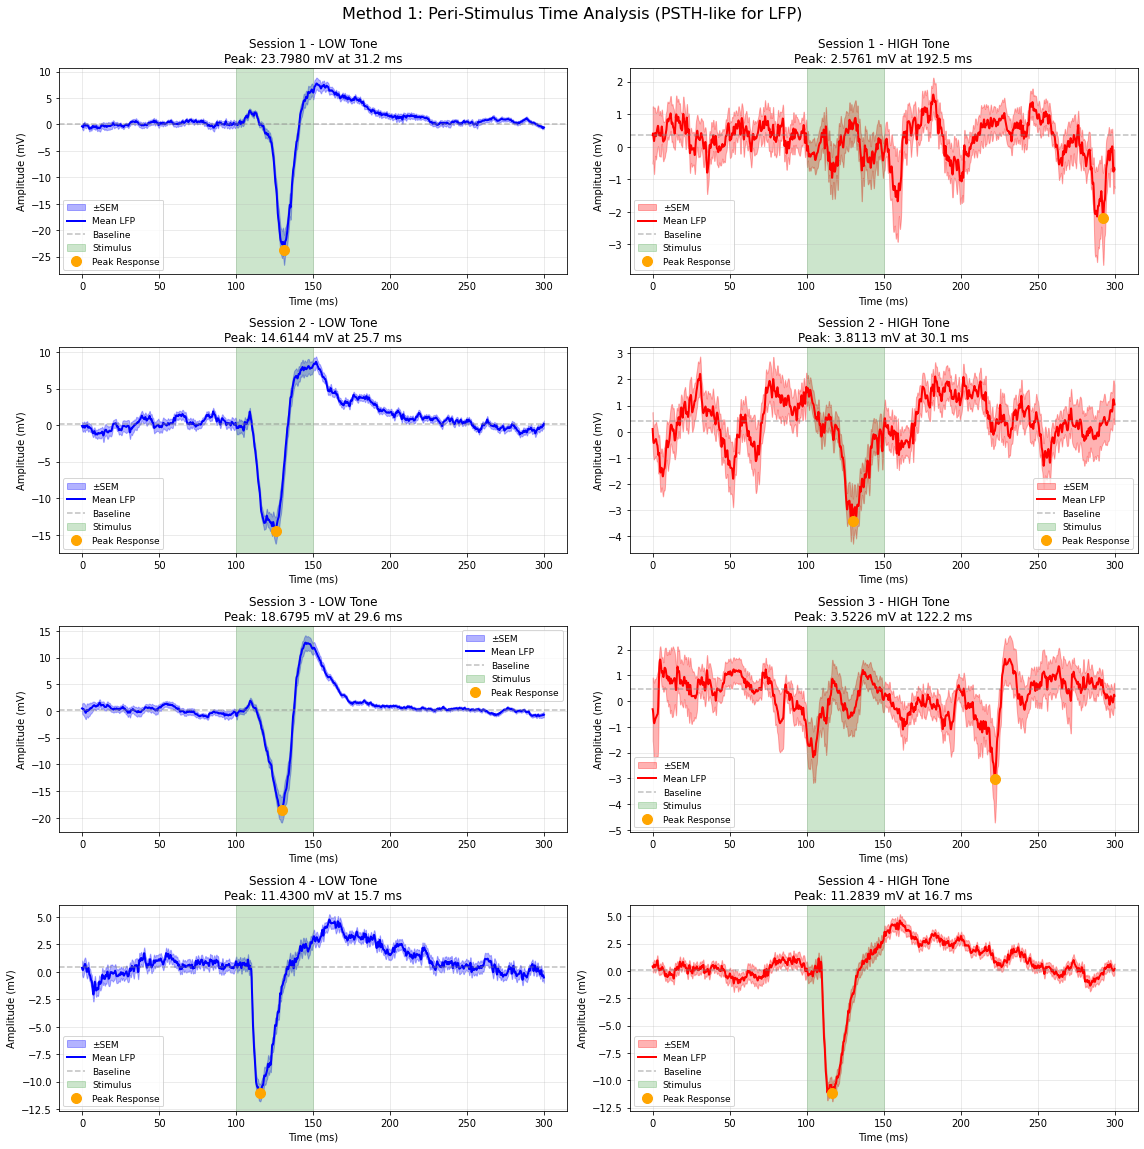

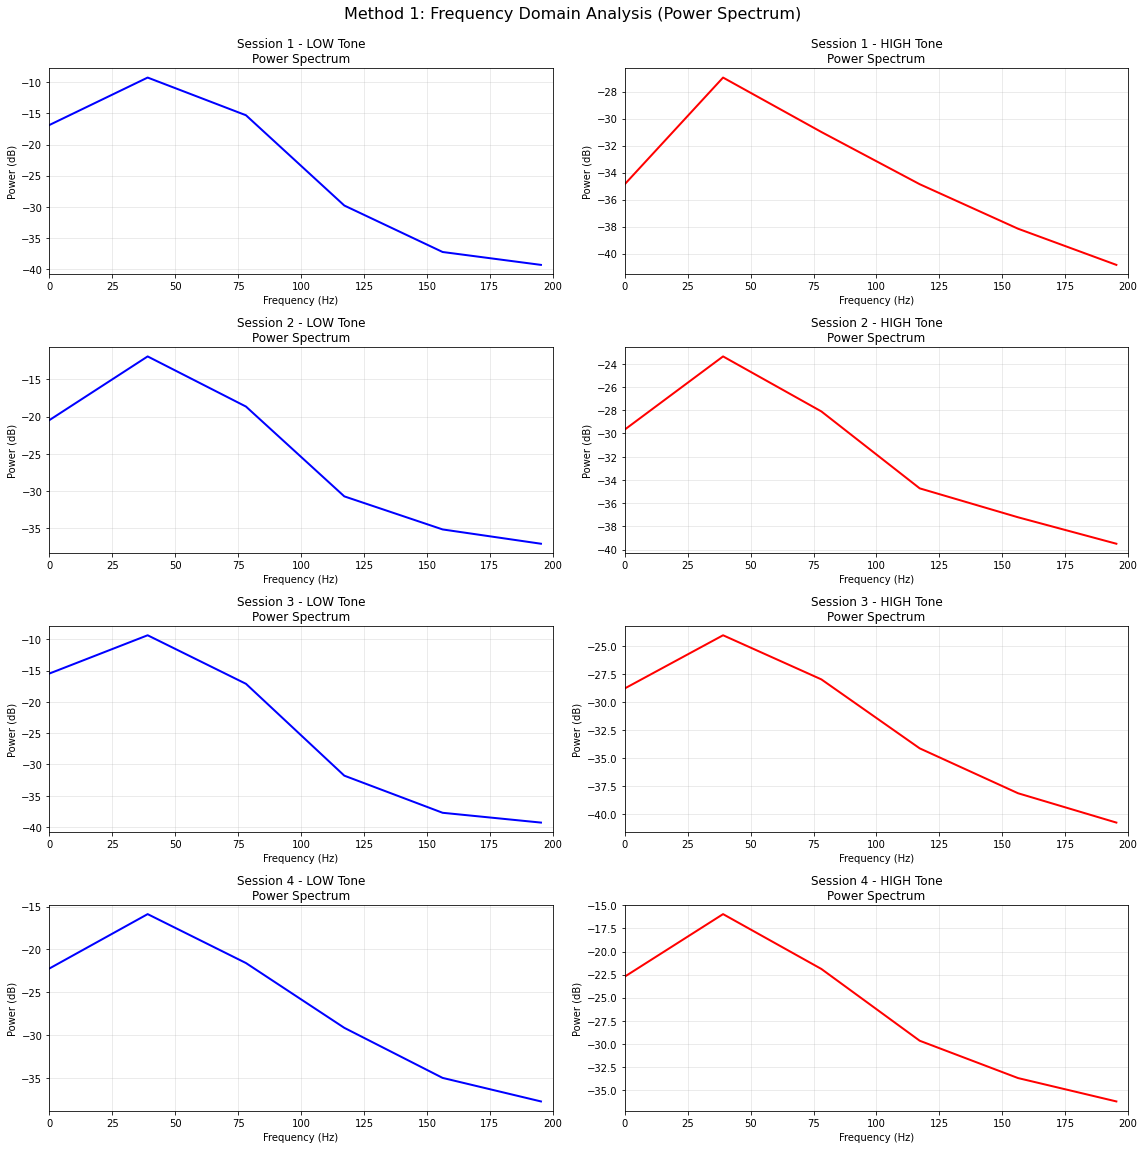

In [12]:
# Time domain visualization
visualize_method1_time(meanLFPs, semLFPs, responseMetrics, numSessions, time_ms, 
                       stimOnset, stimOffset, fs)

# Frequency domain visualization
visualize_method1_frequency(meanLFPs, numSessions, fs)


### 6.2 Method 2: Cross-Session and Cross-Condition Correlation Analysis

This method examines correlations between sessions and between tone conditions.


Method 2: Cross-Session and Cross-Condition Correlation Analysis

LOW Tone - Cross-Session Correlation Matrix:
[[1.         0.55015677 0.84347574 0.38326892]
 [0.55015677 1.         0.81075688 0.83970476]
 [0.84347574 0.81075688 1.         0.52562328]
 [0.38326892 0.83970476 0.52562328 1.        ]]
  Global Mean Correlation: 0.6588

HIGH Tone - Cross-Session Correlation Matrix:
[[ 1.          0.0272029  -0.02538395  0.08290739]
 [ 0.0272029   1.         -0.24129141  0.27204754]
 [-0.02538395 -0.24129141  1.         -0.14488876]
 [ 0.08290739  0.27204754 -0.14488876  1.        ]]
  Global Mean Correlation: -0.0049

Session 1 - Low vs High Tone Correlation: -0.1046

Session 2 - Low vs High Tone Correlation: 0.2502

Session 3 - Low vs High Tone Correlation: 0.0529

Session 4 - Low vs High Tone Correlation: 0.9599

Overall Mean Cross-Condition Correlation: 0.2896


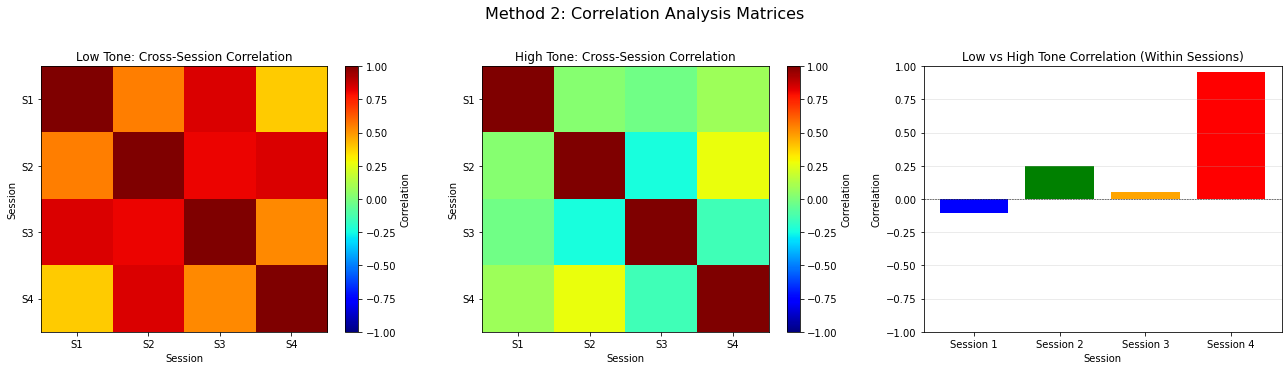

In [13]:
# Perform Method 2 analysis
rSC_sessions, rSC_conditions = method2_correlation_analysis(meanLFPs, numSessions)

# Visualize correlation matrices
visualize_method2_correlation(rSC_sessions, rSC_conditions, numSessions)


### 6.3 Combined Sessions Analysis

Analyze data combined across all sessions and compare with individual session results.


Combined Analysis Across All Sessions
Combined Low Tone: 391 trials
Combined High Tone: 385 trials


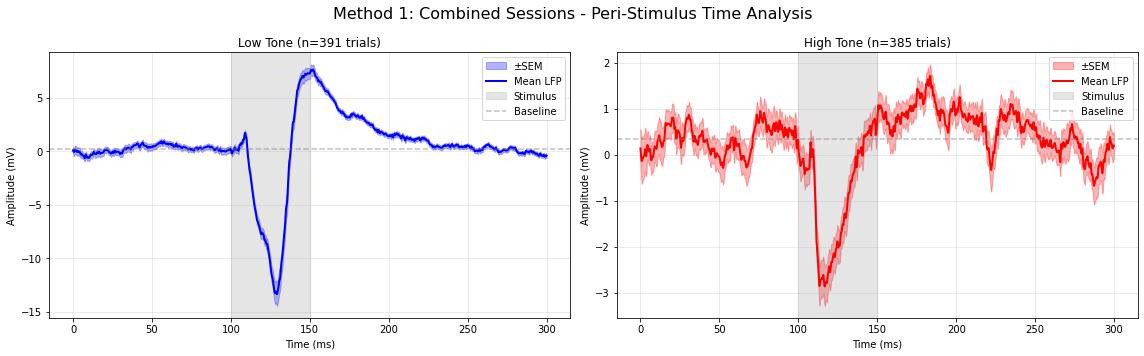

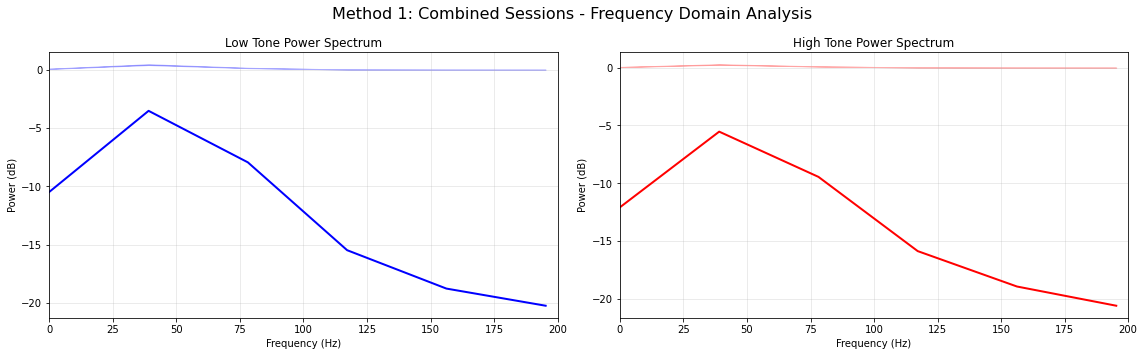


Method 2: Combined Sessions - Correlation Analysis

Combined Sessions - Low vs High Tone Correlation: 0.7315

Comparison with Individual Sessions:
  Session 1: -0.1046
  Session 2: 0.2502
  Session 3: 0.0529
  Session 4: 0.9599


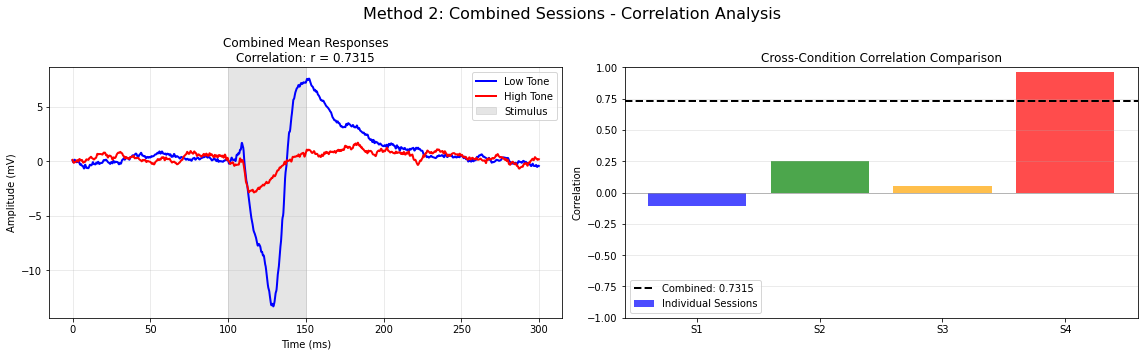


Combined Sessions - Frequency Domain Correlation: 0.9879



In [14]:
# Combined analysis across all sessions
lfp_combined, r_combined_conditions, r_combined_freq = combined_sessions_analysis(
    filteredData, numSessions, meanLFPs, rSC_conditions, 
    stimOnset, stimOffset, fs
)


## 7. Saving Results <a name="saving"></a>

Save all analysis results for later use.


In [15]:
# Create results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)

# Save results
save_results(
    rawData, filteredData, toneIndices, outlierIndices,
    trialsBeforeRejection, trialsAfterRejection,
    cutoffFrequency, fs, stimOnset, stimOffset, numSessions, dataSamples,
    output_dir='../results'
)

print("Results saved successfully!")
print("  - ../results/analysis_results.pkl")
print("  - ../results/analysis_results.npz")


Results saved successfully!
  - ../results/analysis_results.pkl
  - ../results/analysis_results.npz


## Summary

This tutorial demonstrated the complete LFP analysis pipeline:

1. **Data Loading**: Load MATLAB data files
2. **Outlier Detection**: Identify and remove noisy trials using high-frequency power analysis
3. **Signal Filtering**: Apply low-pass filter to remove high-frequency noise
4. **Analysis Method 1**: PSTH-like time domain analysis
5. **Analysis Method 2**: Correlation analysis across sessions and conditions
6. **Combined Analysis**: Analysis across all sessions combined
7. **Results Saving**: Save all results for later use

### Key Functions by Module

- **data_loader**: `load_data()`, `inspect_data()`
- **outlier_detection**: `find_tone_indices()`, `detect_outliers()`, `remove_outliers()`
- **filtering**: `apply_filter()`, `visualize_filtering()`
- **analysis**: `method1_psth_analysis()`, `method2_correlation_analysis()`, `combined_sessions_analysis()`
- **data_saver**: `save_results()`

For more details, see the source code in the `src/` directory and the main execution script `main.py`.
